In [47]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [48]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [49]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [50]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [51]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [52]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [53]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [54]:
# Create our session (link) from Python to the DB
session=Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [55]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [56]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
trip_temps = calc_temps('2017-08-01', '2017-08-07')
trip_temps

[(72.0, 79.25, 83.0)]

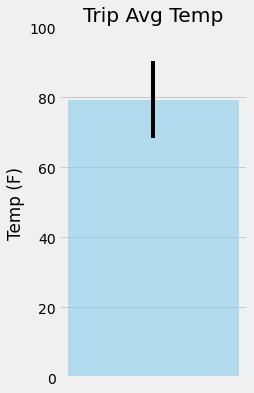

In [57]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

plt.figure(figsize=(3,6))
plt.bar(0, avg_temp, yerr=[max_temp-min_temp], color = 'skyblue', alpha=.6)
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.xticks([])

plt.show()

### Daily Rainfall Average

In [58]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-08-01'
end_date = '2017-08-01'

station_info = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= start_date)\
.filter(Measurement.date <= end_date)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

for row in station_info:
    print (f"Station:  {row[0]}\n    Rainfall:  {row[1]}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()

Station:  USC00516128
    Rainfall:  157.91000000000005  
    Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4      Latitude:  21.3331  Longitude:  -157.8025

Station:  USC00519281
    Rainfall:  79.49000000000005  
    Location:  WAIHEE 837.5, HI US
    Elevation:  32.9      Latitude:  21.45167  Longitude:  -157.84888999999998

Station:  USC00513117
    Rainfall:  54.39000000000004  
    Location:  KANEOHE 838.1, HI US
    Elevation:  14.6      Latitude:  21.4234  Longitude:  -157.8015

Station:  USC00519523
    Rainfall:  39.800000000000004  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00514830
    Rainfall:  34.25999999999999  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00519397
    Rainfall:  17.199999999999992  
    Location:  WAIKIKI 717.2, HI US
    Elevation:  3.0      Latitude:  21.271

In [59]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [60]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_ranges = pd.date_range(start_date, end_date)

# Strip off the year and save a list of strings in the format %m-%d
holiday_date = date_ranges.strftime("%m-%d")

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for date in holiday_date:
    normals.append(*daily_normals(date))

In [61]:
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [62]:
#Load query into a dataframe
normals_df = pd.DataFrame(normals, columns=['Min temp','Avg temp','Max temp'])

In [64]:
#Set date as index
normals_df['Date']=holiday_date
normals_df.set_index('Date')

,Min temp,Avg temp,Max temp
Date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


<AxesSubplot:>

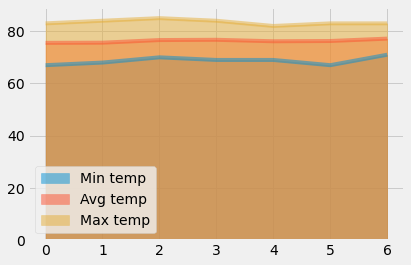

In [65]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)

## Close Session

In [45]:
session.close()